In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.decomposition import PCA
import plotly.express as px
import re
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from calendar import day_abbr, month_abbr, mdays
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from random import randint




Using TensorFlow backend.


## Part 1: Data Acquistion

In [3]:
df_all = pd.read_csv('data/AAPL.csv')
df_AAPL = pd.read_csv('data/AAPL.csv')
df_AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-09-01,27.537500,27.969999,26.840000,26.930000,24.444548,307383600
1,2015-09-02,27.557501,28.084999,27.282499,28.084999,25.492954,247555200
2,2015-09-03,28.122499,28.195000,27.510000,27.592501,25.045906,212935600
3,2015-09-04,27.242500,27.612499,27.127501,27.317499,24.796288,199985200
4,2015-09-08,27.937500,28.139999,27.580000,28.077499,25.486139,219374400
...,...,...,...,...,...,...,...
2058,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700
2059,2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300
2060,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000
2061,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.889999,49340300


In [4]:
df_AAPL['Date'] = pd.to_datetime(df_AAPL['Date'], infer_datetime_format=True)
df_AAPL = df_AAPL.set_index('Date', drop=True)
df_AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-09-01,27.537500,27.969999,26.840000,26.930000,24.444548,307383600
2015-09-02,27.557501,28.084999,27.282499,28.084999,25.492954,247555200
2015-09-03,28.122499,28.195000,27.510000,27.592501,25.045906,212935600
2015-09-04,27.242500,27.612499,27.127501,27.317499,24.796288,199985200
2015-09-08,27.937500,28.139999,27.580000,28.077499,25.486139,219374400
...,...,...,...,...,...,...
2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700
2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000


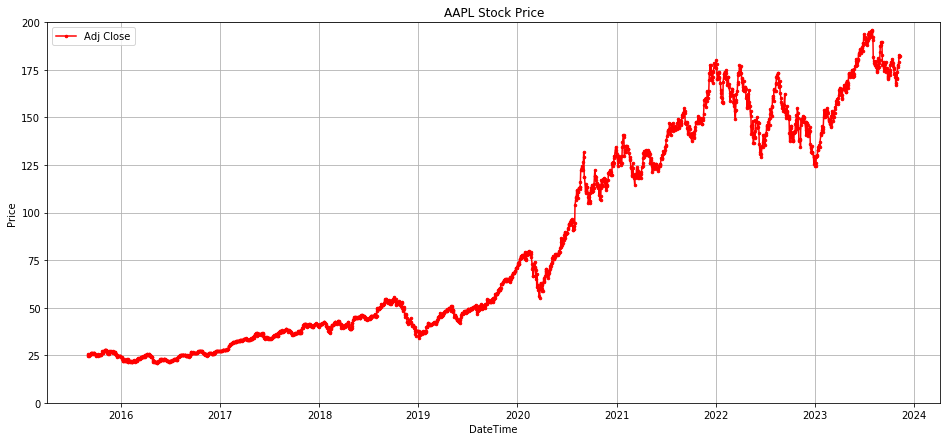

In [5]:
#Apple stock Adj Close price Trend
plt.figure(figsize=(16, 7))
plt.plot(df_AAPL['Adj Close'],label='Adj Close', linestyle='-', marker='.', markersize = '5', c='r')
plt.xlabel('DateTime')
plt.ylabel('Price')

plt.ylim([0, 200])
plt.grid()

plt.legend()
plt.title('AAPL Stock Price')
plt.show()



## Part 2: Data Pre-Processing

In [8]:
# Add moving average, standard deviation data column
ma_day = [10,20,50,100]
for ma in ma_day:
    col_name = f"{ma}days MA"
    df_AAPL[col_name] = df_AAPL['Adj Close'].rolling(ma).mean()
df_AAPL['Std_dev'] = df_AAPL['Adj Close'].rolling(10).std()
df_AAPL['Daily Return'] = df_AAPL['Adj Close'].pct_change()
df_AAPL

,Open,High,Low,Close,Adj Close,Volume,10days MA,20days MA,50days MA,100days MA,Std_dev,Daily Return
Date,,,,,,,,,,,,
2015-09-01,27.537500,27.969999,26.840000,26.930000,24.444548,307383600,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-02,27.557501,28.084999,27.282499,28.084999,25.492954,247555200,NaN,NaN,NaN,NaN,NaN,0.042889
2015-09-03,28.122499,28.195000,27.510000,27.592501,25.045906,212935600,NaN,NaN,NaN,NaN,NaN,-0.017536
2015-09-04,27.242500,27.612499,27.127501,27.317499,24.796288,199985200,NaN,NaN,NaN,NaN,NaN,-0.009966
2015-09-08,27.937500,28.139999,27.580000,28.077499,25.486139,219374400,NaN,NaN,NaN,NaN,NaN,0.027821
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700,172.190001,174.934501,176.587801,181.575741,3.413835,-0.005181
2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300,172.813000,174.946501,176.600201,181.531021,4.081293,0.014605
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000,173.651001,175.118001,176.632801,181.491630,4.984678,0.014451


In [9]:
df_AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume,10days MA,20days MA,50days MA,100days MA,Std_dev,Daily Return
count,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2.063000e+03,2054.000000,2044.000000,2014.000000,1964.000000,2054.000000,2062.000000
mean,86.474125,87.444678,85.572617,86.553183,84.868353,1.173948e+08,84.791812,84.720092,84.485224,84.005378,1.823269,0.001146
std,54.870416,55.520032,54.271317,54.923657,55.381426,5.972338e+07,55.206087,55.043739,54.511483,53.485462,1.608008,0.018498
min,22.500000,22.917500,22.367500,22.584999,20.826057,3.145820e+07,21.359280,21.637232,22.061270,22.927958,0.085660,-0.128647
25%,38.997500,39.313750,38.628750,38.984999,36.835486,7.720955e+07,36.991753,37.023817,37.679447,38.834256,0.535446,-0.007520
50%,57.020000,57.482498,56.657501,56.997501,55.197227,1.028140e+08,55.099728,55.248595,56.197415,56.837141,1.271170,0.000947
75%,142.699997,144.339996,140.934998,142.820000,141.563110,1.391926e+08,141.994467,142.400212,142.353368,142.371565,2.740655,0.010353
max,196.240005,198.229996,195.279999,196.449997,196.185074,5.334788e+08,193.953090,192.371725,187.194618,182.409528,8.204170,0.119808


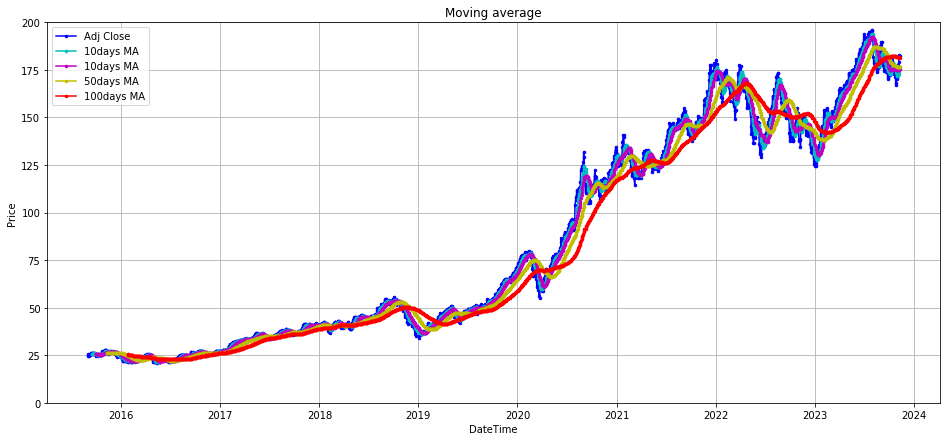

In [72]:
plt.figure(figsize=(16, 7))
plt.plot(df['Adj Close'],label='Adj Close', linestyle='-', marker='.', markersize = '5', c='b')
plt.plot(df['10days MA'],label='10days MA', linestyle='-', marker='.', markersize = '5', c='c')
plt.plot(df['20days MA'],label='10days MA', linestyle='-', marker='.', markersize = '5', c='m')
plt.plot(df['50days MA'],label='50days MA', linestyle='-', marker='.', markersize = '5', c='y')
plt.plot(df['100days MA'],label='100days MA', linestyle='-', marker='.', markersize = '5', c='r')
plt.xlabel('DateTime')
plt.ylabel('Price')

plt.ylim([0, 200])
plt.grid()
plt.legend()
plt.savefig('image/AAPL_Moving_Average.jpg')
plt.title('Moving average')
plt.show()

### Missing values

In [10]:
# Check for missing values
print(df_AAPL.isnull().any().describe())


count       12
unique       2
top       True
freq         6
dtype: object


In [11]:
#The current result shows that there is a null value, but it is as expected because the sliding window generated 
#during the calculation of the moving average will cause the null to occur
df_AAPL.isnull().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
10days MA        9
20days MA       19
50days MA       49
100days MA      99
Std_dev          9
Daily Return     1
dtype: int64

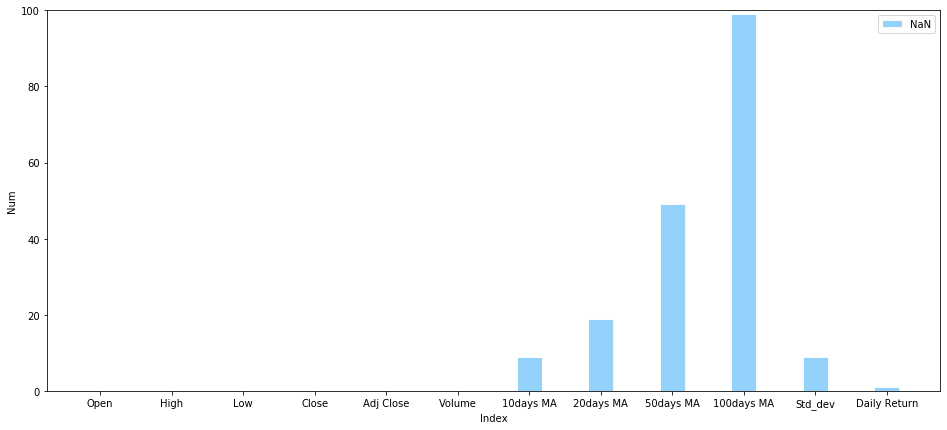

In [13]:
# Counting the number of missing values
df_missing = df_AAPL.isnull().sum()
plt.figure(figsize=(16, 7))
plt.bar(df_missing.index,df_missing,alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white', label='NaN', lw=1)
plt.xlabel('Index')
plt.ylabel('Num')

plt.ylim([0, 100])
plt.legend()
plt.savefig('image/AAPL_missing_value.jpg')
plt.show()

In [14]:
#Fill all null values with 0
df_AAPL = df_AAPL.fillna(value=0)
df_AAPL

,Open,High,Low,Close,Adj Close,Volume,10days MA,20days MA,50days MA,100days MA,Std_dev,Daily Return
Date,,,,,,,,,,,,
2015-09-01,27.537500,27.969999,26.840000,26.930000,24.444548,307383600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-09-02,27.557501,28.084999,27.282499,28.084999,25.492954,247555200,0.000000,0.000000,0.000000,0.000000,0.000000,0.042889
2015-09-03,28.122499,28.195000,27.510000,27.592501,25.045906,212935600,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017536
2015-09-04,27.242500,27.612499,27.127501,27.317499,24.796288,199985200,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009966
2015-09-08,27.937500,28.139999,27.580000,28.077499,25.486139,219374400,0.000000,0.000000,0.000000,0.000000,0.000000,0.027821
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700,172.190001,174.934501,176.587801,181.575741,3.413835,-0.005181
2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300,172.813000,174.946501,176.600201,181.531021,4.081293,0.014605
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000,173.651001,175.118001,176.632801,181.491630,4.984678,0.014451


### Outlier

In [12]:
#Calculating outlier by zscore
def detect_outlier_by_zscore(df):
    columns = df.columns
    z_scores = []
#     for attr in columns:
    z = np.abs(stats.zscore(df['Adj Close']))
    z_scores.append(z)

    plt.figure(figsize=(16,7))
    date_x = df.index
    plt.xlabel('Date')
    plt.ylabel('Z score')
    plt.grid()
    index = 0
    for z_score in z_scores:
        plt.plot_date(date_x, z_score, '-',linewidth=1, label='Adj Close')
        index += 1
    plt.legend()
    plt.savefig('image/AAPL_outlier.jpg')
    return

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '10days MA',
       '20days MA', '50days MA', '100days MA', 'Std_dev', 'Daily Return'],
      dtype='object')

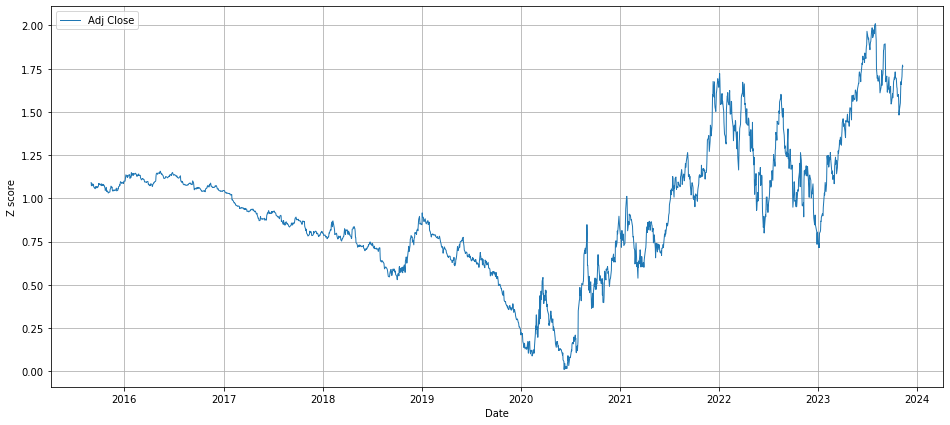

In [13]:
detect_outlier_by_zscore(df_AAPL)
df_AAPL.columns

### Normaliazation

In [17]:
# Normalise all features using StandardScaler to scale them to the 0-1 interval
def Data_Normalization(array):
    
    std_scaler = StandardScaler()
    df_std = std_scaler.fit_transform(array)
    return df_std

In [18]:
df_AAPL.values

array([[ 2.75375000e+01,  2.79699990e+01,  2.68400000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.75575010e+01,  2.80849990e+01,  2.72824990e+01, ...,
         0.00000000e+00,  0.00000000e+00,  4.28891547e-02],
       [ 2.81224990e+01,  2.81950000e+01,  2.75100000e+01, ...,
         0.00000000e+00,  0.00000000e+00, -1.75361396e-02],
       ...,
       [ 1.79179993e+02,  1.82440002e+02,  1.78970001e+02, ...,
         1.81491630e+02,  4.98467847e+00,  1.44507675e-02],
       [ 1.82350006e+02,  1.83449997e+02,  1.81589996e+02, ...,
         1.81473824e+02,  5.66249155e+00,  5.88489692e-03],
       [ 1.82960007e+02,  1.84119995e+02,  1.81809998e+02, ...,
         1.81450319e+02,  5.36345744e+00, -2.62450108e-03]])

In [19]:
df_std = Data_Normalization(df_AAPL.values)

## Part 3: Data Exploration

### Explore dependency on day of the week and month for Adj Close

In [66]:
month_day = df[['Adj Close']][:-63].copy()
# month_day = month_day.set_index('Date', drop=True)
weekday=[]
for i in month_day.index:

    weekday.append(i.weekday()+1)
month_day['weekday']=weekday
month_day.loc[:,'month']=month_day.index.month
month_day = month_day.groupby(['weekday','month']).mean().unstack()
month_day.columns = month_day.columns.droplevel(0)
month_day

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
1,84.081914,79.804553,80.965956,81.905826,86.790596,80.433955,88.656569,90.755979,74.775884,74.328870,78.503212,78.943219
2,78.895719,82.790968,82.198202,83.038205,83.777503,86.795494,86.765549,91.042960,75.789952,73.164541,79.632195,80.269231
3,77.279398,82.640810,83.384995,83.431928,82.521303,86.838490,91.662430,88.309176,77.929746,73.853412,76.303350,83.274522
4,78.066553,82.148629,81.049969,85.002068,80.915007,86.562710,94.168814,87.373735,78.371261,74.537061,74.635891,81.678855
5,79.785051,81.896746,81.853685,82.924731,82.401726,85.716875,92.813205,88.601097,74.908976,76.813435,76.002270,77.920919


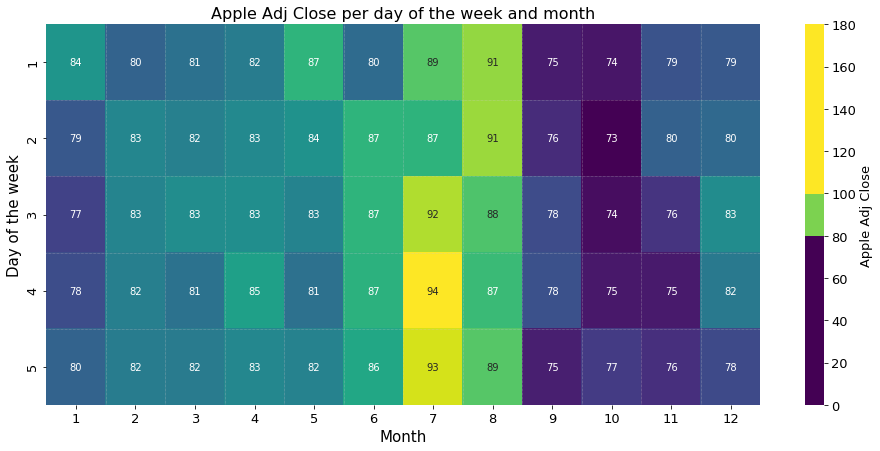

In [67]:
# it can be seen that although the stock market is not cyclical, May and June were generally lower
f, ax = plt.subplots(figsize=(16,7))

sn.heatmap(month_day, ax = ax, annot = True,cmap=plt.cm.viridis, cbar_kws={'boundaries':np.arange(0,200,20)})

cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('Apple Adj Close', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('Apple Adj Close per day of the week and month', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Day of the week', fontsize=15)
# ax.set_yticklabels(day_abbr[0:7])
plt.savefig('image/Apple_Adj_Close_per_day_of_week_and_month_heatmap.jpg')

## Part 4: Dataset Division

In [31]:
# Calculate the number of samples needed for the training and test sets
df_ds = df_all
training_size = int(len(df_ds)*0.8)
data_len = len(df_ds)
df_train, df_test = df_ds[0:training_size],df_ds[training_size:data_len]

print("Training Size: ", training_size)
print("total length of data: ", data_len)
print("Train length:", len(df_train))
print("Test length:", len(df_test))

Training Size:  1650
total length of data:  2063
Train length: 1650
Test length: 413


In [30]:
# Normalise the training set by scaling the different features to the interval 0-1
df_train = df_train.loc[:, ["Close"]].values
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train)

In [32]:
# Add the data to the list of features and labels in the corresponding training set
end_len = len(train_scaled)
X_train = []
y_train = []
timesteps = 40

for i in range(timesteps, end_len):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training set : ", X_train.shape)
print("Shape of training label : ", y_train.shape)


Shape of training set :  (1610, 40)
Shape of training label :  (1610,)


In [33]:
# Shape of training set features & labels
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train --> ", X_train.shape)
print("y_train shape --> ", y_train.shape)

X_train -->  (1610, 40, 1)
y_train shape -->  (1610,)


In [38]:
# Normalise the test set by scaling the different features to an interval of 0-1
real_price = df_test.loc[:, ["Close"]].values
dataset_total = pd.concat((df_ds["Close"], df_test["Close"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - timesteps:].values.reshape(-1,1)
# print("Shape of test set：", inputs.shape)
inputs = scaler.transform(inputs)

In [42]:
# Add the data in turn to the list of features in the corresponding test set.
X_test = []
for i in range(timesteps, 453):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("X_test shape: ", X_test.shape)

X_test shape:  (413, 40, 1)


## Part 5: Model Training, Inference and Evaluation

### 1. RNN

In [43]:
# Model building
model = Sequential()
model.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 40, 50)            2600      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40, 50)            5050      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,751
Trainable params: 12,751
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Setting up Adam as optimiser and compiling the model
optimizer = Adam(0.0005)
model.compile(optimizer= optimizer, loss = "mean_squared_error")


In [76]:
# ------------------Training-----------------------
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=64, callbacks=[learning_rate_reduction])

Train on 1449 samples, validate on 161 samples
Epoch 1/200
1449/1449 [==============================] - 4s 3ms/step - loss: 0.4125 - val_loss: 0.4239
Epoch 2/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0757 - val_loss: 0.2993
Epoch 3/200
1449/1449 [==============================] - 3s 2ms/step - loss: 0.0400 - val_loss: 0.2182
Epoch 4/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0248 - val_loss: 0.2159
Epoch 5/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0229 - val_loss: 0.1758
Epoch 6/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0177 - val_loss: 0.1827
Epoch 7/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0161 - val_loss: 0.1560
Epoch 8/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0145 - val_loss: 0.1281
Epoch 9/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.1223
Epoch 10/200
1449/1449 [==

1449/1449 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0608
Epoch 153/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0600
Epoch 154/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0620
Epoch 155/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0599
Epoch 156/200
1449/1449 [==============================] - 2s 1ms/step - loss: 0.0066 - val_loss: 0.0644
Epoch 157/200
1449/1449 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0608
Epoch 158/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0611
Epoch 159/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0599
Epoch 160/200
1449/1449 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0611
Epoch 161/200
1449/1449 [==============================] - 1s 1ms/ste

In [83]:
#Saving weight of model
model.save_weights('model/model_RNN_weights.h5')

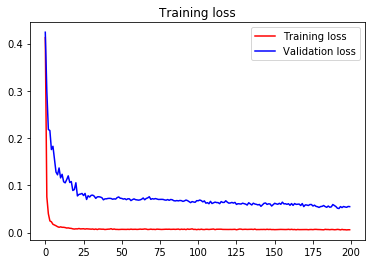

<Figure size 432x288 with 0 Axes>

In [77]:
# plot the loss curves on training and validation set
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [78]:
# model prediction
train_predict=model.predict(X_train)
train_predict.shape

(1610, 1)

In [80]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [81]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3.6836744598278397
Train data MSE:  13.569457525987925
Train data MAE:  1.8590343262505762
-------------------------------------------------------------------------------------
Test data RMSE:  13.13910871382709
Test data MSE:  172.63617779376696
Test data MAE:  10.82236734614648


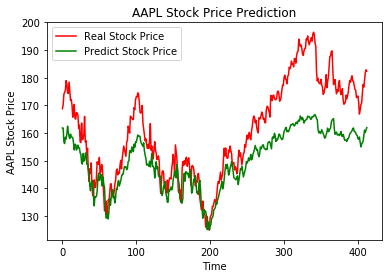

In [82]:
# Plotting forecast and real share price curves
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()

### 2. LSTM

In [18]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=16, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 16)            1152      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_lstm = model_lstm.fit(X_train, y_train,validation_split=0.25, epochs=200, batch_size=64)

Train on 1207 samples, validate on 403 samples
Epoch 1/200
1207/1207 [==============================] - 12s 10ms/step - loss: 0.2707 - root_mean_squared_error: 0.6283 - val_loss: 2.1631 - val_root_mean_squared_error: 0.7034
Epoch 2/200
1207/1207 [==============================] - 4s 4ms/step - loss: 0.0567 - root_mean_squared_error: 0.7476 - val_loss: 1.8315 - val_root_mean_squared_error: 0.7255
Epoch 3/200
1207/1207 [==============================] - 4s 3ms/step - loss: 0.0380 - root_mean_squared_error: 0.7274 - val_loss: 1.5736 - val_root_mean_squared_error: 0.7086
Epoch 4/200
1207/1207 [==============================] - 3s 3ms/step - loss: 0.0273 - root_mean_squared_error: 0.7040 - val_loss: 1.3678 - val_root_mean_squared_error: 0.6877
Epoch 5/200
1207/1207 [==============================] - 4s 3ms/step - loss: 0.0227 - root_mean_squared_error: 0.6817 - val_loss: 1.1494 - val_root_mean_squared_error: 0.6664
Epoch 6/200
1207/1207 [==============================] - 3s 3ms/step - loss:

1207/1207 [==============================] - 3s 2ms/step - loss: 0.0069 - root_mean_squared_error: 0.2713 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2707
Epoch 94/200
1207/1207 [==============================] - 3s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.2701 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2695
Epoch 95/200
1207/1207 [==============================] - 4s 4ms/step - loss: 0.0057 - root_mean_squared_error: 0.2690 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2684
Epoch 96/200
1207/1207 [==============================] - 4s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.2679 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2673
Epoch 97/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0052 - root_mean_squared_error: 0.2668 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2663
Epoch 98/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0054 - root_mean_squared_error: 0.2658 - val_loss: 0.

1207/1207 [==============================] - 5s 5ms/step - loss: 0.0042 - root_mean_squared_error: 0.2093 - val_loss: 0.0329 - val_root_mean_squared_error: 0.2091
Epoch 186/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0041 - root_mean_squared_error: 0.2089 - val_loss: 0.0343 - val_root_mean_squared_error: 0.2087
Epoch 187/200
1207/1207 [==============================] - 4s 3ms/step - loss: 0.0044 - root_mean_squared_error: 0.2085 - val_loss: 0.0381 - val_root_mean_squared_error: 0.2082
Epoch 188/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0044 - root_mean_squared_error: 0.2081 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2079
Epoch 189/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0044 - root_mean_squared_error: 0.2077 - val_loss: 0.0332 - val_root_mean_squared_error: 0.2075
Epoch 190/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0042 - root_mean_squared_error: 0.2073 - val_los

In [76]:
model_lstm.save_weights('model/model_lstm_weights.h5')

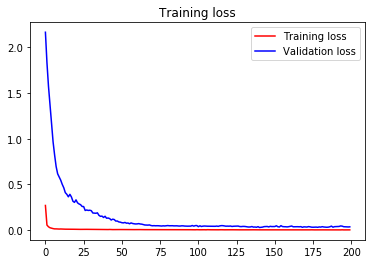

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [87]:
train_predict=model_lstm.predict(X_train)
train_predict.shape

(1610, 1)

In [89]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [90]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3.8104027712898545
Train data MSE:  14.519169279453404
Train data MAE:  2.238265768665385
-------------------------------------------------------------------------------------
Test data RMSE:  10.598066480859904
Test data MSE:  112.31901313272623
Test data MAE:  8.393043671004841


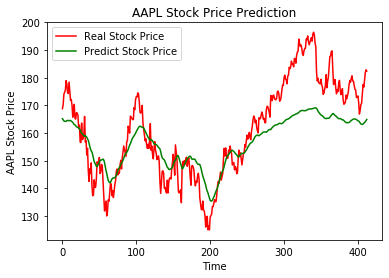

In [91]:
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()

### 3. Base GRU

In [44]:

model_GRU=Sequential()
model_GRU.add(GRU(32,return_sequences=True,input_shape=(40,1)))
model_GRU.add(GRU(32,return_sequences=True))
model_GRU.add(GRU(32))
model_GRU.add(Dense(1))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 32)            3264      
_________________________________________________________________
gru_2 (GRU)                  (None, 40, 32)            6240      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_GRU.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
# fit model
history_GRU = model_GRU.fit(X_train, y_train, validation_split = 0.25, epochs = 200, batch_size = 32)


Train on 1207 samples, validate on 403 samples
Epoch 1/200
1207/1207 [==============================] - 18s 15ms/step - loss: 0.0745 - val_loss: 0.1896
Epoch 2/200
1207/1207 [==============================] - 9s 8ms/step - loss: 0.0022 - val_loss: 0.0537
Epoch 3/200
1207/1207 [==============================] - 17s 14ms/step - loss: 0.0014 - val_loss: 0.0583
Epoch 4/200
1207/1207 [==============================] - 11s 9ms/step - loss: 0.0014 - val_loss: 0.0510
Epoch 5/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0013 - val_loss: 0.0508
Epoch 6/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0013 - val_loss: 0.0492
Epoch 7/200
1207/1207 [==============================] - 11s 9ms/step - loss: 0.0013 - val_loss: 0.0530
Epoch 8/200
1207/1207 [==============================] - 11s 9ms/step - loss: 0.0012 - val_loss: 0.0480
Epoch 9/200
1207/1207 [==============================] - 9s 8ms/step - loss: 0.0012 - val_loss: 0.0420
Epoch 10/200
1207/1

1207/1207 [==============================] - 9s 7ms/step - loss: 5.4760e-04 - val_loss: 0.0098
Epoch 152/200
1207/1207 [==============================] - 10s 8ms/step - loss: 5.9111e-04 - val_loss: 0.0053
Epoch 153/200
1207/1207 [==============================] - 9s 7ms/step - loss: 5.6227e-04 - val_loss: 0.0083
Epoch 154/200
1207/1207 [==============================] - 10s 8ms/step - loss: 5.6924e-04 - val_loss: 0.0119
Epoch 155/200
1207/1207 [==============================] - 12s 10ms/step - loss: 5.5592e-04 - val_loss: 0.0093
Epoch 156/200
1207/1207 [==============================] - 9s 7ms/step - loss: 5.5589e-04 - val_loss: 0.0079
Epoch 157/200
1207/1207 [==============================] - 9s 7ms/step - loss: 5.9649e-04 - val_loss: 0.0071
Epoch 158/200
1207/1207 [==============================] - 9s 7ms/step - loss: 5.5747e-04 - val_loss: 0.0063
Epoch 159/200
1207/1207 [==============================] - 8s 7ms/step - loss: 6.1837e-04 - val_loss: 0.0056
Epoch 160/200
1207/1207 [====

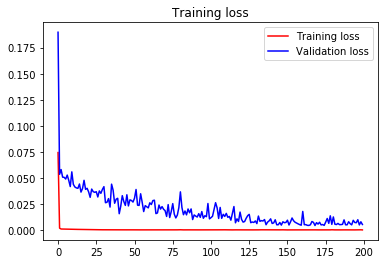

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [17]:

train_predict=model_GRU.predict(X_train)
train_predict.shape

(1610, 1)

In [18]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [19]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1.9329027492152977
Train data MSE:  3.7361130379240564
Train data MAE:  1.1631193566479034
-------------------------------------------------------------------------------------
Test data RMSE:  5.669095005669201
Test data MSE:  32.13863818330347
Test data MAE:  4.562443915170297


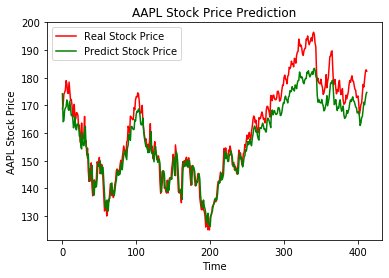

In [20]:
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()

### 3.1 Add Dropout

In [13]:
model_GRU=Sequential()
model_GRU.add(GRU(32,return_sequences=True,input_shape=(40,1)))
model_GRU.add(GRU(32,return_sequences=True))
model_GRU.add(GRU(32))
model_GRU.add(Dropout(0.30))
model_GRU.add(Dense(1))


In [17]:
model_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 32)            3264      
_________________________________________________________________
gru_2 (GRU)                  (None, 40, 32)            6240      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_GRU.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
history_GRU = model_GRU.fit(X_train, y_train,validation_split = 0.25, epochs = 200, batch_size = 32)

Train on 1207 samples, validate on 403 samples
Epoch 1/200
1207/1207 [==============================] - 19s 16ms/step - loss: 0.0889 - val_loss: 0.2139
Epoch 2/200
1207/1207 [==============================] - 11s 9ms/step - loss: 0.0118 - val_loss: 0.0482
Epoch 3/200
1207/1207 [==============================] - 11s 9ms/step - loss: 0.0094 - val_loss: 0.0443
Epoch 4/200
1207/1207 [==============================] - 9s 8ms/step - loss: 0.0079 - val_loss: 0.0281
Epoch 5/200
1207/1207 [==============================] - 10s 8ms/step - loss: 0.0075 - val_loss: 0.0338
Epoch 6/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0074 - val_loss: 0.0242
Epoch 7/200
1207/1207 [==============================] - 10s 8ms/step - loss: 0.0074 - val_loss: 0.0188
Epoch 8/200
1207/1207 [==============================] - 10s 9ms/step - loss: 0.0072 - val_loss: 0.0178
Epoch 9/200
1207/1207 [==============================] - 10s 9ms/step - loss: 0.0066 - val_loss: 0.0221
Epoch 10/200
1207/

1207/1207 [==============================] - 9s 8ms/step - loss: 0.0033 - val_loss: 0.0234
Epoch 157/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0035 - val_loss: 0.0202
Epoch 158/200
1207/1207 [==============================] - 9s 8ms/step - loss: 0.0027 - val_loss: 0.0203
Epoch 159/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0033 - val_loss: 0.0094
Epoch 160/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0031 - val_loss: 0.0207
Epoch 161/200
1207/1207 [==============================] - 9s 8ms/step - loss: 0.0027 - val_loss: 0.0231
Epoch 162/200
1207/1207 [==============================] - 10s 8ms/step - loss: 0.0028 - val_loss: 0.0407
Epoch 163/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 164/200
1207/1207 [==============================] - 9s 7ms/step - loss: 0.0034 - val_loss: 0.0218
Epoch 165/200
1207/1207 [==============================] - 9s 8ms/st

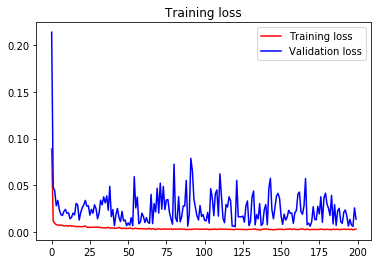

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [21]:

train_predict=model_GRU.predict(X_train)

train_predict.shape

(1610, 1)

In [22]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [23]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.7630392939846002
Train data MSE:  7.634386140102917
Train data MAE:  1.4570824512627072
-------------------------------------------------------------------------------------
Test data RMSE:  8.586743608890794
Test data MSE:  73.73216580482689
Test data MAE:  7.395725494228114


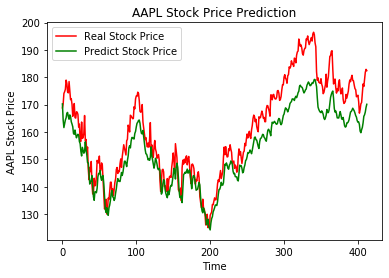

In [24]:
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()

### 3.2 Add LR Scheduler

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                                     patience=3,
                                                     verbose=1,
                                                     factor=0.5,
                                                     min_lr=0.00001)

# fit model
history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=64, callbacks=[learning_rate_reduction])

Train on 1207 samples, validate on 403 samples
Epoch 1/200
1207/1207 [==============================] - 13s 11ms/step - loss: 0.0720 - val_loss: 0.3813
Epoch 2/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0192 - val_loss: 0.1279
Epoch 3/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0115 - val_loss: 0.0738
Epoch 4/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0104 - val_loss: 0.0710
Epoch 5/200
1207/1207 [==============================] - 7s 6ms/step - loss: 0.0094 - val_loss: 0.0716
Epoch 6/200
1207/1207 [==============================] - 7s 6ms/step - loss: 0.0085 - val_loss: 0.0649
Epoch 7/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0083 - val_loss: 0.0754
Epoch 8/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0078 - val_loss: 0.0800
Epoch 9/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0080 - val_loss: 0.0767

Epoch 00009: ReduceLROn

1207/1207 [==============================] - 5s 4ms/step - loss: 0.0061 - val_loss: 0.0569
Epoch 75/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0058 - val_loss: 0.0551
Epoch 76/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0064 - val_loss: 0.0540
Epoch 77/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0064 - val_loss: 0.0542
Epoch 78/200
1207/1207 [==============================] - 7s 5ms/step - loss: 0.0060 - val_loss: 0.0555
Epoch 79/200
1207/1207 [==============================] - 7s 5ms/step - loss: 0.0056 - val_loss: 0.0554
Epoch 80/200
1207/1207 [==============================] - 5s 5ms/step - loss: 0.0063 - val_loss: 0.0541
Epoch 81/200
1207/1207 [==============================] - 5s 4ms/step - loss: 0.0068 - val_loss: 0.0544
Epoch 82/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0064 - val_loss: 0.0545
Epoch 83/200
1207/1207 [==============================] - 5s 4ms/step - loss:

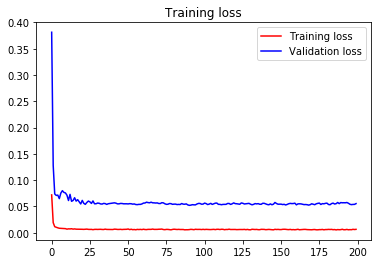

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model_GRU.predict(X_train)

train_predict.shape

(1610, 1)

In [24]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [25]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.161363706701423
Train data MSE:  17.316947899451808
Train data MAE:  2.2126072996626007
-------------------------------------------------------------------------------------
Test data RMSE:  13.143419840526317
Test data MSE:  172.7494851043408
Test data MAE:  11.354726553680198


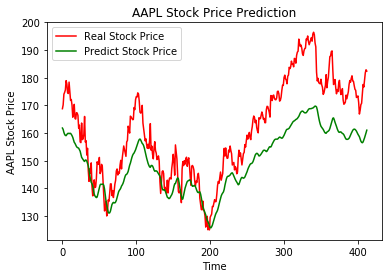

In [26]:
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()

In [27]:
model_GRU.save_weights('model/model_GRU_lr_reduction_weights.h5')

### 3.3 Add more units

In [41]:
model_GRU=Sequential()
model_GRU.add(GRU(64,return_sequences=True,input_shape=(40,1)))
model_GRU.add(GRU(64,return_sequences=True))
model_GRU.add(GRU(64))
model_GRU.add(Dropout(0.20))
model_GRU.add(Dense(1))

model_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 40, 64)            12672     
_________________________________________________________________
gru_8 (GRU)                  (None, 40, 64)            24768     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 62,273
Trainable params: 62,273
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_GRU.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                                     patience=3,
                                                     verbose=1,
                                                     factor=0.5,
                                                     min_lr=0.00001)

# fit model
history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=64, callbacks=[learning_rate_reduction])

Train on 1207 samples, validate on 403 samples
Epoch 1/200
1207/1207 [==============================] - 18s 15ms/step - loss: 0.0863 - val_loss: 0.3303
Epoch 2/200
1207/1207 [==============================] - 8s 7ms/step - loss: 0.0092 - val_loss: 0.0356
Epoch 3/200
1207/1207 [==============================] - 7s 6ms/step - loss: 0.0048 - val_loss: 0.0141
Epoch 4/200
1207/1207 [==============================] - 7s 5ms/step - loss: 0.0040 - val_loss: 0.0187
Epoch 5/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0041 - val_loss: 0.0197
Epoch 6/200
1207/1207 [==============================] - 8s 6ms/step - loss: 0.0038 - val_loss: 0.0146

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/200
1207/1207 [==============================] - 8s 7ms/step - loss: 0.0041 - val_loss: 0.0137
Epoch 8/200
1207/1207 [==============================] - 7s 6ms/step - loss: 0.0034 - val_loss: 0.0154
Epoch 9/200
1207/1207 [=======================

1207/1207 [==============================] - 6s 5ms/step - loss: 0.0030 - val_loss: 0.0121
Epoch 75/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0030 - val_loss: 0.0121
Epoch 76/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0029 - val_loss: 0.0122
Epoch 77/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0028 - val_loss: 0.0121
Epoch 78/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0029 - val_loss: 0.0119
Epoch 79/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0029 - val_loss: 0.0122
Epoch 80/200
1207/1207 [==============================] - 7s 5ms/step - loss: 0.0028 - val_loss: 0.0118
Epoch 81/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0030 - val_loss: 0.0123
Epoch 82/200
1207/1207 [==============================] - 6s 5ms/step - loss: 0.0030 - val_loss: 0.0124
Epoch 83/200
1207/1207 [==============================] - 6s 5ms/step - loss:

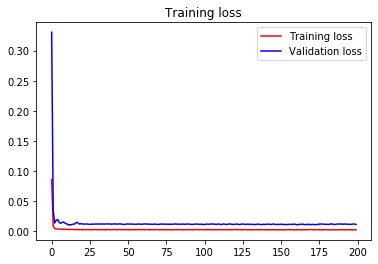

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [45]:
### Lets Do the prediction and check performance metrics
train_predict=model_GRU.predict(X_train)

train_predict.shape

(1610, 1)

In [46]:
# ------------------Evaluation-----------------------
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# print(test_predict.shape)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = real_price

In [47]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.698856844027286
Train data MSE:  7.283828264552922
Train data MAE:  1.5637423310505933
-------------------------------------------------------------------------------------
Test data RMSE:  7.314962796519145
Test data MSE:  53.508680714459196
Test data MAE:  6.080074272374632


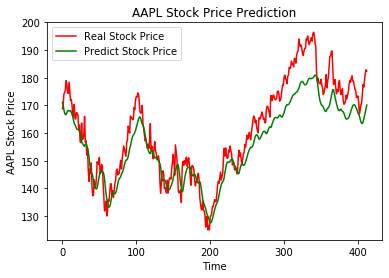

In [48]:
plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(test_predict, color = "green", label = "Predict Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("AAPL Stock Price")
plt.legend()
plt.show()